(Adapted from my solutions to homework problems for ENM531: Data Driven Modelling at UPenn)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

import pyDOE #for Latin Hypercube Sampling

# Binary classification using logistic regression model and neural network for reduced-dimensionality image dataset

In [2]:
#Custom function definitions

#Glorot initialization of weight matrix
def glorot_init_mat(shape):
    din = shape[0]
    dout = shape[1]
    var = torch.tensor([2.0/(din+dout)])
    std = torch.sqrt(var)
    mean = torch.tensor([0.0])
    dist = torch.distributions.normal.Normal(mean, std)
    return dist.sample(shape)

#Mean Squared Error loss function
def MSE_loss(Ypred,Ytrue):
    return torch.mean((Ytrue - Ypred)**2)

def BCE_loss(Ypred,Ytrue):
    return -torch.mean(Ytrue * torch.log(Ypred) + (1-Ytrue) * torch.log(1-Ypred))

#Loss function testing
for i in range(1000):
    #MSE loss test
    y1p = torch.rand(300,1)
    y1t = torch.rand(300,1)
    torch_MSE = nn.MSELoss(reduction='mean')
    assert(torch_MSE(y1p,y1t) - MSE_loss(y1p,y1t) < torch.tensor([1e-4]))
    
    #BCE loss test
    y2 = torch.randint(0,2,(300,1)).type(torch.FloatTensor)
    a2 = torch.rand(300,1).type(torch.FloatTensor)
    torch_BCE = nn.BCELoss(reduction='mean')
    assert(torch_BCE(a2,y2) - BCE_loss(a2,y2) < torch.tensor([1e-4]))


## Prepare data

In [3]:
#Load data from file
data = np.load('Data.npy',allow_pickle=True).item()
X = data['X']
Y = data['Y']
print(X.shape)
print(Y.shape)

#Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.75,shuffle=True)
print(X_train.shape)
print(Y_train.shape)

(3469, 10)
(3469, 1)
(2601, 10)
(2601, 1)


In [4]:
#Convert data into PyTorch tensors
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
Y_test = torch.from_numpy(Y_test).type(torch.FloatTensor)

In [5]:
#Normalize training data
mu = X_train.mean(axis = 0)
sigma = X_train.std(axis = 0)
X_train = (X_train - mu)/sigma
print(X_train.std(axis = 0)) #check that stds are 1

#Normalize test data using same parameters used to normalize training data
X_test = (X_test - mu)/sigma
print(X_test.std(axis = 0)) #check that stds are close to 1

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
tensor([1.0058, 0.9552, 0.9739, 0.9473, 0.9830, 0.9929, 0.9971, 1.0245, 0.9864,
        1.0002])


## Part 1

### Define Logistic Regression NN model and loss function

In [6]:
class LogisticNet(nn.Module):
    def __init__(self):
        super(LogisticNet, self).__init__()
        #Layer definitions
        self.fc = nn.Linear(10,1)
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        x1 = self.fc(x)
        y = self.sig(x1)
        return y

In [7]:
loss_fn = BCE_loss

In [8]:
#Instantiate class
lgst = LogisticNet()

#Initialize weights
#Glorot initialization
[W, b] = list(lgst.fc.parameters())
W = glorot_init_mat(W.shape)
b.data.fill_(0)

print(list(lgst.fc.parameters()))

[Parameter containing:
tensor([[-0.2608,  0.2109, -0.2649,  0.2672,  0.1977,  0.0077,  0.2718, -0.2432,
          0.1017,  0.2293]], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)]


CPU times: user 9.96 s, sys: 13.2 s, total: 23.1 s
Wall time: 7.87 s


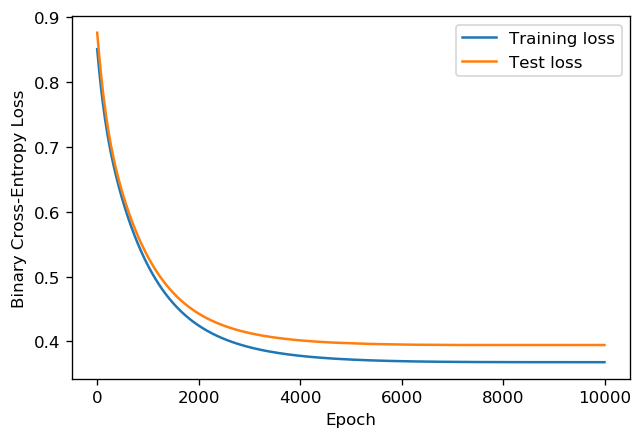

In [9]:
%%time
#Hyperparameters
MAX_EPOCHS = 10000
LRATE = 1e-3

#Use stochastic gradient descent for training
#learning_rate = 0.01
#optimizer = torch.optim.SGD(lgst.parameters(), lr=learning_rate)

#Use Adam for training, with default parameters
optimizer = torch.optim.Adam(lgst.parameters(), lr=LRATE)

loss_history = []
test_loss_history = []

for epoch in range(MAX_EPOCHS):
    Ypred = lgst(X_train)
    loss = loss_fn(Ypred,Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #calculate test loss
    Yt_pred = lgst(X_test)
    test_loss = loss_fn(Yt_pred,Y_test)
    loss_history.append([epoch,np.float(loss)])
    test_loss_history.append([epoch,np.float(test_loss)])

loss_history = np.array(loss_history)
test_loss_history = np.array(test_loss_history)
fig, ax = plt.subplots(dpi=120)
ax.plot(loss_history[:,0], loss_history[:,1], label="Training loss")
ax.plot(test_loss_history[:,0], test_loss_history[:,1], label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Binary Cross-Entropy Loss")
ax.legend()

In [10]:
#Report final losses
print(loss_history[-1,1], test_loss_history[-1,1])

0.3679666519165039 0.39443323016166687


In [11]:
#Training accuracy
Yp_train = lgst(X_train)
Yp_train = Yp_train.data.numpy()
#Predict data classes
Yp_train = np.where(Yp_train < 0.5, 0, 1)
#Compare to training data
Y_train_true = Y_train.data.numpy()
compare = np.absolute(Yp_train - Y_train_true).reshape(len(Y_train_true),)
print("Training accuracy: {:.2f}%".format((1 - np.sum(compare)/len(compare))*100))
#Confusion matrix
cf = confusion_matrix(Y_train_true,Yp_train).astype(np.float64)
#true 0 predicted 0, true 0 predicted 1
#true 1 predicted 0, true 1 predicted 1
#Normalize confusion matrix
cf[0,:] = cf[0,:]/np.sum(cf[0,:])
cf[1,:] = cf[1,:]/np.sum(cf[1,:])
print("Normalized confusion matrix:\n", np.array_str(cf, precision=3, suppress_small=True))

Training accuracy: 83.24%
Normalized confusion matrix:
 [[0.993 0.007]
 [0.328 0.672]]


In [12]:
#Test accuracy
Yp_test = lgst(X_test)
Yp_test = Yp_test.data.numpy()
#Predict data classes
Yp_test = np.where(Yp_test < 0.5, 0, 1)
#Compare to training data
Y_test_true = Y_test.data.numpy()
compare = np.absolute(Yp_test - Y_test_true).reshape(len(Y_test_true),)
print("Test accuracy: {:.2f}%".format((1 - np.sum(compare)/len(compare))*100))
#Confusion matrix
cf = confusion_matrix(Y_test_true,Yp_test).astype(np.float64)
#true 0 predicted 0, true 0 predicted 1
#true 1 predicted 0, true 1 predicted 1
#Normalize confusion matrix
cf[0,:] = cf[0,:]/np.sum(cf[0,:])
cf[1,:] = cf[1,:]/np.sum(cf[1,:])
print("Normalized confusion matrix:\n", np.array_str(cf, precision=3, suppress_small=True))

Test accuracy: 81.22%
Normalized confusion matrix:
 [[0.988 0.012]
 [0.35  0.65 ]]


## Part 2

### Custom dataset

In [13]:
#Custom Dataset
class BCDataset(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx], self.Y[idx]

### Define multilayer deep neural network model

In [14]:
class FCNet(nn.Module):
    def __init__(self):
        p = 0.0 #dropout probability
        
        super(FCNet, self).__init__()
        self.FC1 = nn.Linear(10,20)
        self.dropout1 = nn.Dropout(p)
        self.relu1 = nn.LeakyReLU()
        
        self.FC2 = nn.Linear(20,20)
        self.dropout2 = nn.Dropout(p)
        self.relu2 = nn.LeakyReLU()
        
        self.FC3 = nn.Linear(20,1)
        self.dropout3 = nn.Dropout(p)
        
        self.act = nn.Sigmoid()
        
    def forward(self, x):
        x1 = self.FC1(x)
        x1d = self.dropout1(x1)
        x1a = self.relu1(x1d)
        
        x2 = self.FC2(x1a)
        x2d = self.dropout2(x2)
        x2a = self.relu2(x2d)
        
        x3 = self.FC3(x2a)
        x3d = self.dropout1(x3)
        
        y = self.act(x3d)
        return y

In [15]:
loss_fn = BCE_loss

In [16]:
#Instantiate class
fcn = FCNet()

#Initialize weights
#Glorot initialization
[W, b] = list(fcn.FC1.parameters())
W = glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(fcn.FC2.parameters())
W = glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(fcn.FC3.parameters())
W = glorot_init_mat(W.shape)
b.data.fill_(0)

tensor([0.])

In [17]:
%%time
#Hyperparameters
MAX_EPOCHS = 2500
LRATE = 1e-4
BATCH_SIZE = X_train.shape[0] #full batch gradient descent

#Data handling
traindata = BCDataset(X_train,Y_train)
traindataloader = torch.utils.data.DataLoader(traindata,batch_size=BATCH_SIZE,shuffle=True)

#Use Adam for training
optimizer = torch.optim.Adam(fcn.parameters(),lr=LRATE)

loss_history = []
test_loss_history = []

for epoch in range(MAX_EPOCHS):
    #Train net in batches
    for Xbatch, Ybatch in traindataloader:
        Ypred = fcn(Xbatch)
        loss = loss_fn(Ypred,Ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #calculate train loss
    Ytrain_pred = fcn(X_train)
    train_loss = loss_fn(Ytrain_pred,Y_train)
    #calculate test loss
    Ytest_pred = fcn(X_test)
    test_loss = loss_fn(Ytest_pred,Y_test)
    #append loss history
    loss_history.append([epoch,np.float(train_loss)])
    test_loss_history.append([epoch,np.float(test_loss)])
    if (epoch+1) % 200 == 0:
        print("Epoch: {}, Train loss: {:.4f}, Test loss: {:.4f}".format((epoch+1), train_loss, test_loss))

Epoch: 200, Train loss: 0.6781, Test loss: 0.6801
Epoch: 400, Train loss: 0.6302, Test loss: 0.6355
Epoch: 600, Train loss: 0.5498, Test loss: 0.5600
Epoch: 800, Train loss: 0.4657, Test loss: 0.4813
Epoch: 1000, Train loss: 0.4106, Test loss: 0.4321
Epoch: 1200, Train loss: 0.3823, Test loss: 0.4092
Epoch: 1400, Train loss: 0.3678, Test loss: 0.3991
Epoch: 1600, Train loss: 0.3595, Test loss: 0.3946
Epoch: 1800, Train loss: 0.3543, Test loss: 0.3920
Epoch: 2000, Train loss: 0.3504, Test loss: 0.3901
Epoch: 2200, Train loss: 0.3469, Test loss: 0.3884
Epoch: 2400, Train loss: 0.3444, Test loss: 0.3874
CPU times: user 1min 48s, sys: 3min 1s, total: 4min 50s
Wall time: 1min 20s


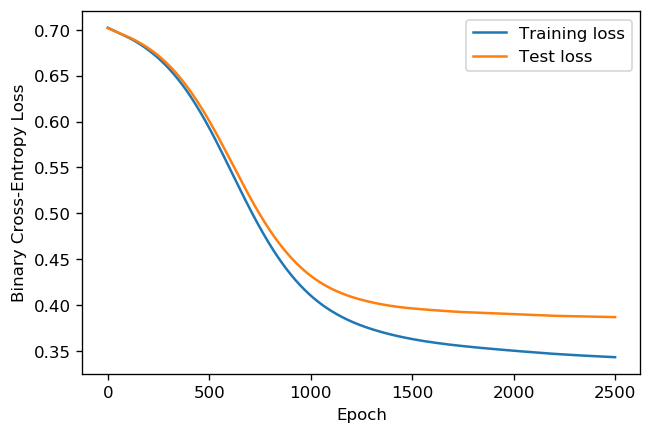

In [18]:
loss_history = np.array(loss_history)
test_loss_history = np.array(test_loss_history)
fig, ax = plt.subplots(dpi=120)
ax.plot(loss_history[:,0], loss_history[:,1], label="Training loss")
ax.plot(test_loss_history[:,0], test_loss_history[:,1], label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Binary Cross-Entropy Loss")
ax.legend()

In [19]:
#Report final losses
print(loss_history[-1,1], test_loss_history[-1,1])

0.34331852197647095 0.3869973123073578


In [20]:
#Training accuracy
Yp_train = fcn(X_train)
Yp_train = Yp_train.data.numpy()
#Predict data classes
Yp_train = np.where(Yp_train < 0.5, 0, 1)
#Compare to training data
Y_train_true = Y_train.data.numpy()
compare = np.absolute(Yp_train - Y_train_true).reshape(len(Y_train_true),)
print("Training accuracy: {:.2f}%".format((1 - np.sum(compare)/len(compare))*100))
#Confusion matrix
cf = confusion_matrix(Y_train_true,Yp_train).astype(np.float64)
#true 0 predicted 0, true 0 predicted 1
#true 1 predicted 0, true 1 predicted 1
#Normalize confusion matrix
cf[0,:] = cf[0,:]/np.sum(cf[0,:])
cf[1,:] = cf[1,:]/np.sum(cf[1,:])
print("Normalized confusion matrix:\n", np.array_str(cf, precision=3, suppress_small=True))

Training accuracy: 83.81%
Normalized confusion matrix:
 [[0.988 0.012]
 [0.312 0.688]]


In [21]:
#Test accuracy
Yp_test = fcn(X_test)
Yp_test = Yp_test.data.numpy()
#Predict data classes
Yp_test = np.where(Yp_test < 0.5, 0, 1)
#Compare to training data
Y_test_true = Y_test.data.numpy()
compare = np.absolute(Yp_test - Y_test_true).reshape(len(Y_test_true),)
print("Test accuracy: {:.2f}%".format((1 - np.sum(compare)/len(compare))*100))
#Confusion matrix
cf = confusion_matrix(Y_test_true,Yp_test).astype(np.float64)
#true 0 predicted 0, true 0 predicted 1
#true 1 predicted 0, true 1 predicted 1
#Normalize confusion matrix
cf[0,:] = cf[0,:]/np.sum(cf[0,:])
cf[1,:] = cf[1,:]/np.sum(cf[1,:])
print("Normalized confusion matrix:\n", np.array_str(cf, precision=3, suppress_small=True))

Test accuracy: 81.45%
Normalized confusion matrix:
 [[0.978 0.022]
 [0.337 0.663]]


## Changing training and test data size

Training size: 0.8
Training set shape (2775, 10)
Test set shape (2775, 1)
Epoch: 200, Train loss: 0.6665, Test loss: 0.6636
Epoch: 400, Train loss: 0.6163, Test loss: 0.6140
Epoch: 600, Train loss: 0.5382, Test loss: 0.5388
Epoch: 800, Train loss: 0.4581, Test loss: 0.4635
Epoch: 1000, Train loss: 0.4058, Test loss: 0.4182
Epoch: 1200, Train loss: 0.3795, Test loss: 0.3986
Epoch: 1400, Train loss: 0.3666, Test loss: 0.3905
Epoch: 1600, Train loss: 0.3594, Test loss: 0.3864
Epoch: 1800, Train loss: 0.3545, Test loss: 0.3844
Epoch: 2000, Train loss: 0.3507, Test loss: 0.3832
Epoch: 2200, Train loss: 0.3475, Test loss: 0.3825
Epoch: 2400, Train loss: 0.3448, Test loss: 0.3817
Train loss:  0.3437100648880005 Test loss:  0.38149306178092957
Training accuracy: 83.93%
Normalized confusion matrix:
 [[0.993 0.007]
 [0.315 0.685]]
Test accuracy: 81.27%
Normalized confusion matrix:
 [[0.973 0.027]
 [0.332 0.668]]
Training size: 0.7
Training set shape (2428, 10)
Test set shape (2428, 1)
Epoch: 200

UsageError: Line magic function `%%time` not found.


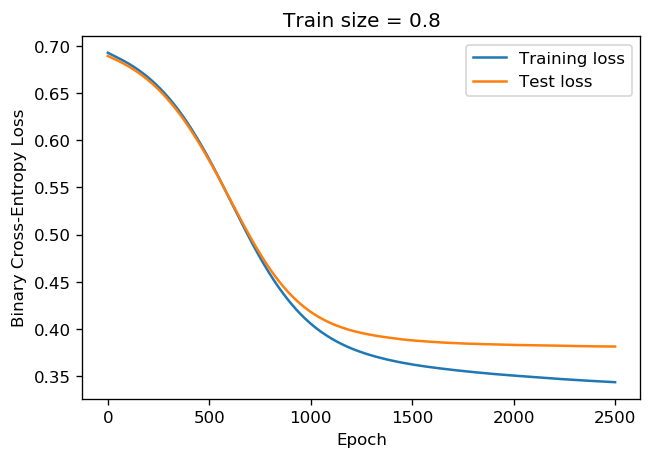

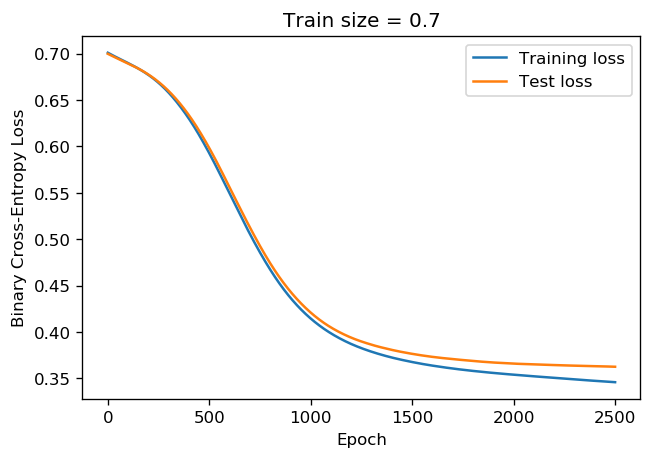

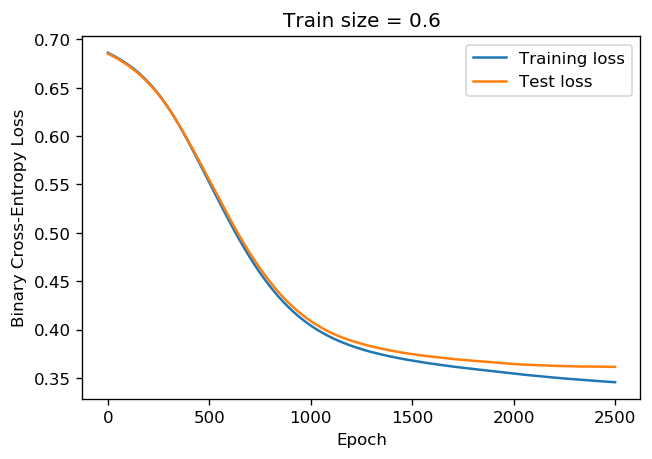

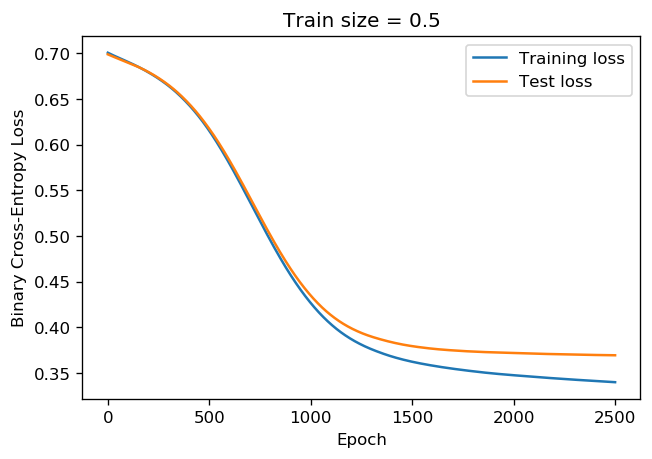

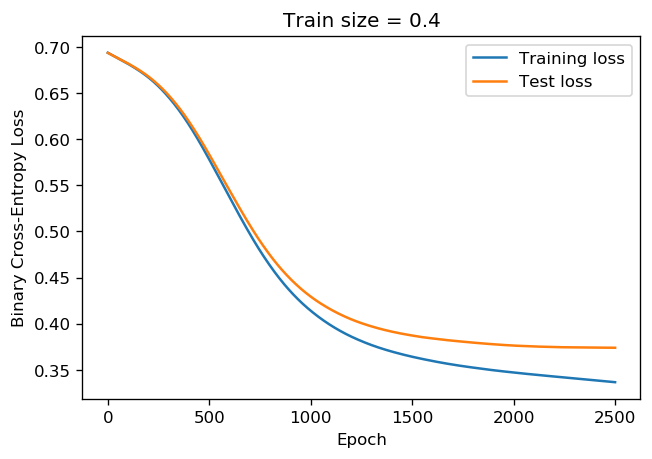

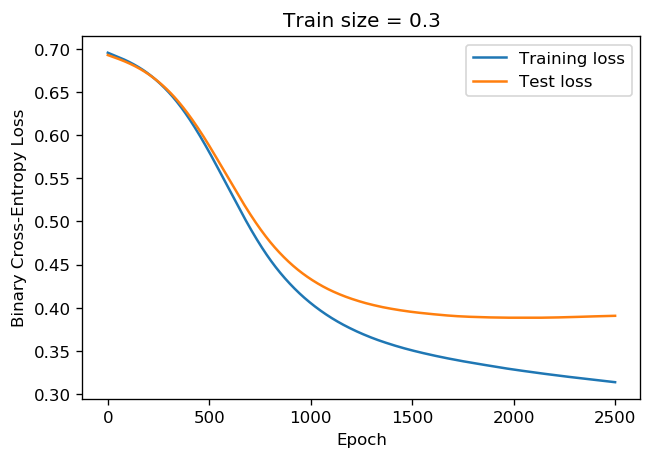

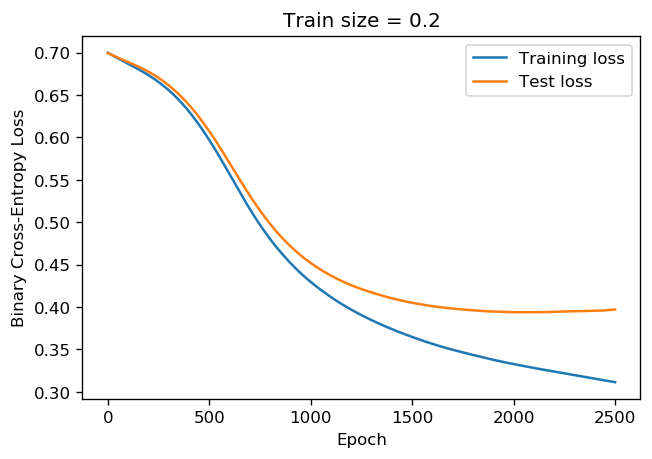

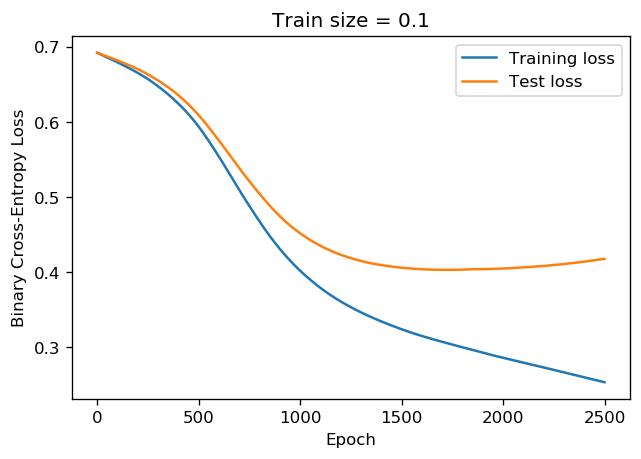

In [22]:
%%time
ntests = 8
train_sizes = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
max_epochs = [2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500]
finaltrainlosses = []
finaltestlosses = []
trainaccs = []
testaccs = []

for i in range(ntests):
    train_size = train_sizes[i]
    max_epoch = max_epochs[i]
    
    print("Training size: {}".format(train_size))
    
    #Load data from file
    data = np.load('Data.npy',allow_pickle=True).item()
    X = data['X']
    Y = data['Y']

    #Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=train_size,shuffle=True)
    print("Training set shape", X_train.shape)
    print("Test set shape", Y_train.shape)
    
    #Convert data into PyTorch tensors
    X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
    Y_test = torch.from_numpy(Y_test).type(torch.FloatTensor)
    
    #Normalize training data
    mu = X_train.mean(axis = 0)
    sigma = X_train.std(axis = 0)
    X_train = (X_train - mu)/sigma

    #Normalize test data using same parameters used to normalize training data
    X_test = (X_test - mu)/sigma
    loss_fn = BCE_loss
    
    #Instantiate class
    fcn = FCNet()

    #Initialize weights
    #Glorot initialization
    [W, b] = list(fcn.FC1.parameters())
    W = glorot_init_mat(W.shape)
    b.data.fill_(0)

    [W, b] = list(fcn.FC2.parameters())
    W = glorot_init_mat(W.shape)
    b.data.fill_(0)

    [W, b] = list(fcn.FC3.parameters())
    W = glorot_init_mat(W.shape)
    b.data.fill_(0)

    #Hyperparameters
    MAX_EPOCHS = max_epoch
    LRATE = 1e-4
    BATCH_SIZE = X_train.shape[0]

    #Data handling
    traindata = BCDataset(X_train,Y_train)
    traindataloader = torch.utils.data.DataLoader(traindata,batch_size=BATCH_SIZE,shuffle=True)

    #Use Adam for training
    optimizer = torch.optim.Adam(fcn.parameters(),lr=LRATE)

    loss_history = []
    test_loss_history = []

    for epoch in range(MAX_EPOCHS):
        #Train net in batches
        for Xbatch, Ybatch in traindataloader:
            Ypred = fcn(Xbatch)
            loss = loss_fn(Ypred,Ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #calculate train loss
        Ytrain_pred = fcn(X_train)
        train_loss = loss_fn(Ytrain_pred,Y_train)
        #calculate test loss
        Ytest_pred = fcn(X_test)
        test_loss = loss_fn(Ytest_pred,Y_test)
        #append loss history
        loss_history.append([epoch,np.float(train_loss)])
        test_loss_history.append([epoch,np.float(test_loss)])
        if (epoch+1) % 200 == 0:
            print("Epoch: {}, Train loss: {:.4f}, Test loss: {:.4f}".format((epoch+1), train_loss, test_loss))
            
    loss_history = np.array(loss_history)
    test_loss_history = np.array(test_loss_history)
    fig, ax = plt.subplots(dpi=120)
    ax.plot(loss_history[:,0], loss_history[:,1], label="Training loss")
    ax.plot(test_loss_history[:,0], test_loss_history[:,1], label="Test loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Binary Cross-Entropy Loss")
    ax.set_title("Train size = {}".format(train_size))
    ax.legend()
    
    #Report final losses
    print("Train loss: ", loss_history[-1,1], "Test loss: ", test_loss_history[-1,1])
    
    #Training accuracy
    Yp_train = fcn(X_train)
    Yp_train = Yp_train.data.numpy()
    #Predict data classes
    Yp_train = np.where(Yp_train < 0.5, 0, 1)
    #Compare to training data
    Y_train_true = Y_train.data.numpy()
    compare = np.absolute(Yp_train - Y_train_true).reshape(len(Y_train_true),)
    trainacc = (1 - np.sum(compare)/len(compare))*100
    print("Training accuracy: {:.2f}%".format(trainacc))
    #Confusion matrix
    cf = confusion_matrix(Y_train_true,Yp_train).astype(np.float64)
    #true 0 predicted 0, true 0 predicted 1
    #true 1 predicted 0, true 1 predicted 1
    #Normalize confusion matrix
    cf[0,:] = cf[0,:]/np.sum(cf[0,:])
    cf[1,:] = cf[1,:]/np.sum(cf[1,:])
    print("Normalized confusion matrix:\n", np.array_str(cf, precision=3, suppress_small=True))
    
    #Test accuracy
    Yp_test = fcn(X_test)
    Yp_test = Yp_test.data.numpy()
    #Predict data classes
    Yp_test = np.where(Yp_test < 0.5, 0, 1)
    #Compare to training data
    Y_test_true = Y_test.data.numpy()
    compare = np.absolute(Yp_test - Y_test_true).reshape(len(Y_test_true),)
    testacc = (1 - np.sum(compare)/len(compare))*100
    print("Test accuracy: {:.2f}%".format(testacc))
    #Confusion matrix
    cf = confusion_matrix(Y_test_true,Yp_test).astype(np.float64)
    #true 0 predicted 0, true 0 predicted 1
    #true 1 predicted 0, true 1 predicted 1
    #Normalize confusion matrix
    cf[0,:] = cf[0,:]/np.sum(cf[0,:])
    cf[1,:] = cf[1,:]/np.sum(cf[1,:])
    print("Normalized confusion matrix:\n", np.array_str(cf, precision=3, suppress_small=True))
    
    finaltrainlosses.append(loss_history[-1,1])
    finaltestlosses.append(test_loss_history[-1,1])
    trainaccs.append(trainacc)
    testaccs.append(testacc)

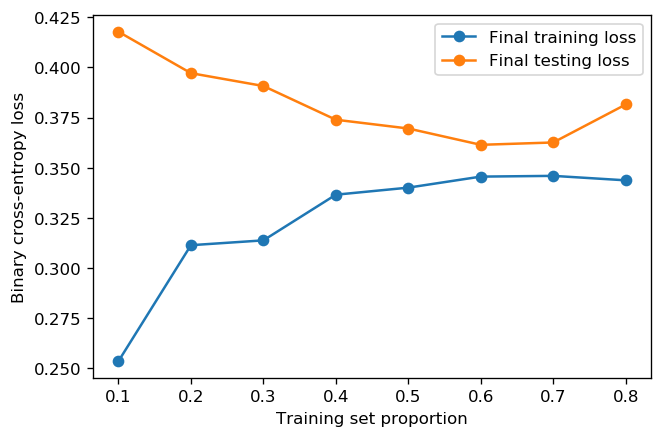

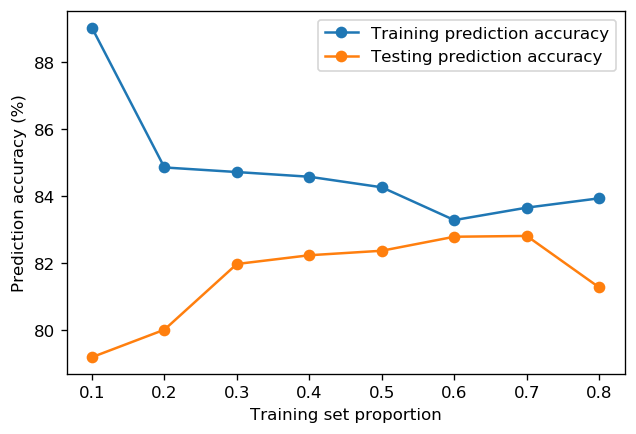

In [58]:
fig, ax = plt.subplots(dpi=120)
ax.plot(np.array(train_sizes), np.array(finaltrainlosses), 'o-', label="Final training loss")
ax.plot(np.array(train_sizes), np.array(finaltestlosses), 'o-', label="Final testing loss")
ax.set_xlabel("Training set proportion")
ax.set_ylabel("Binary cross-entropy loss")
ax.legend()

fig, ax = plt.subplots(dpi=120)
ax.plot(np.array(train_sizes), np.array(trainaccs), 'o-', label="Training prediction accuracy")
ax.plot(np.array(train_sizes), np.array(testaccs), 'o-', label="Testing prediction accuracy")
ax.set_xlabel("Training set proportion")
ax.set_ylabel("Prediction accuracy (%)")
ax.legend()

# Deep neural network to approximate function given data samples

Function to approximate:

$f(x,y) = cos(\pi x)cos(\pi y), x, y \in [50, 54]^2$

Text(0, 0.5, 'f')

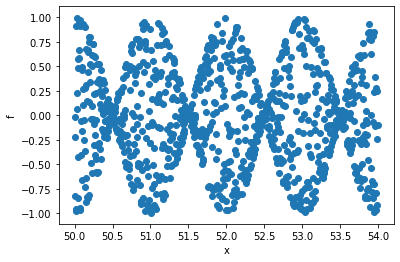

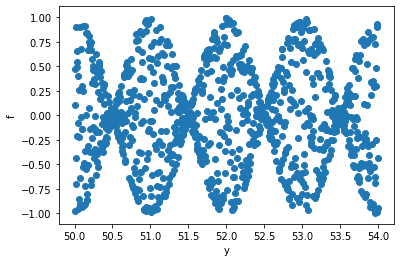

In [24]:
#samples
N = 1000

#sample on LHS
design = pyDOE.lhs(2, samples = N)
x = 50 + 4*design[:,0]
y = 50 + 4*design[:,1]
f = np.cos(np.pi*x)*np.cos(np.pi*y)

#Visualize data
plt.figure()
plt.scatter(x,f)
ax = plt.gca()
ax.set_xlabel('x')
ax.set_ylabel('f')

#Visualize data
plt.figure()
plt.scatter(y,f)
ax = plt.gca()
ax.set_xlabel('y')
ax.set_ylabel('f')

In [25]:
#Prepare training and test data
X = np.transpose(np.vstack((x,y)))
Y = f.reshape(-1,1)
print(X.shape)
print(Y.shape)

#Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8,shuffle=True)
print(X_train.shape)
print(Y_train.shape)

(1000, 2)
(1000, 1)
(800, 2)
(800, 1)


In [26]:
#Normalize training data
mu = X_train.mean(axis = 0)
sigma = X_train.std(axis = 0)
X_train = (X_train - mu)/sigma
print(X_train.std(axis = 0))

#Normalize test data using same parameters used to normalize training data
X_test = (X_test - mu)/sigma
print(X_test.std(axis = 0))

[1. 1.]
[1.01174045 1.00674241]


In [27]:
#Convert data into PyTorch tensors
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
Y_test = torch.from_numpy(Y_test).type(torch.FloatTensor)

## Custom Dataset

In [28]:
#Custom Dataset
class NLRDataset(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx], self.Y[idx]

## Define Neural Network model

In [29]:
#Define Neural network
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.FC1 = nn.Linear(2,50)
        self.tanh1 = nn.Tanh()
        self.FC2 = nn.Linear(50,50)
        self.tanh2 = nn.Tanh()
        self.FC3 = nn.Linear(50,1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x1 = self.FC1(x)
        x2 = self.tanh1(x1)
        x3 = self.FC2(x2)
        x4 = self.tanh2(x3)
        x5 = self.FC3(x4)
        y = self.tanh(x5)
        return y

In [30]:
loss_fn = MSE_loss #as this is a regression problem

## Initialization and training

In [31]:
#Instantiate class
dn = DeepNet()

#Initialize weights
#Glorot initialization
[W, b] = list(dn.FC1.parameters())
W = glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(dn.FC2.parameters())
W = glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(dn.FC3.parameters())
W = glorot_init_mat(W.shape)
b.data.fill_(0)

tensor([0.])

In [32]:
%%time
#Training, perform backprop
MAX_EPOCHS = 5000
LRATE = 1e-3
BATCH_SIZE = 512

#Data handling
traindata = NLRDataset(X_train,Y_train)
traindataloader = torch.utils.data.DataLoader(traindata,batch_size=BATCH_SIZE,shuffle=True)

#Use Adam for training
optimizer = torch.optim.Adam(dn.parameters(), lr=LRATE)

loss_history = []
test_loss_history = []

for epoch in range(MAX_EPOCHS):
    #Train net in batches
    for Xbatch, Ybatch in traindataloader:
        Ypred = dn(Xbatch)
        loss = loss_fn(Ypred,Ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #calculate train loss
    Ytrain_pred = dn(X_train)
    train_loss = loss_fn(Ytrain_pred,Y_train)
    #calculate test loss
    Ytest_pred = dn(X_test)
    test_loss = loss_fn(Ytest_pred,Y_test)
    #append loss history
    loss_history.append([epoch,np.float(train_loss)])
    test_loss_history.append([epoch,np.float(test_loss)])
    if (epoch+1) % 100 == 0:
        print("Epoch: {}, Train loss: {:.4f}, Test loss: {:.4f}".format((epoch+1), train_loss, test_loss))

Epoch: 100, Train loss: 0.2336, Test loss: 0.2685
Epoch: 200, Train loss: 0.2329, Test loss: 0.2680
Epoch: 300, Train loss: 0.2252, Test loss: 0.2571
Epoch: 400, Train loss: 0.2058, Test loss: 0.2334
Epoch: 500, Train loss: 0.1730, Test loss: 0.2032
Epoch: 600, Train loss: 0.1468, Test loss: 0.1771
Epoch: 700, Train loss: 0.1296, Test loss: 0.1547
Epoch: 800, Train loss: 0.1135, Test loss: 0.1345
Epoch: 900, Train loss: 0.0997, Test loss: 0.1143
Epoch: 1000, Train loss: 0.0863, Test loss: 0.1014
Epoch: 1100, Train loss: 0.0768, Test loss: 0.0893
Epoch: 1200, Train loss: 0.0690, Test loss: 0.0771
Epoch: 1300, Train loss: 0.0625, Test loss: 0.0708
Epoch: 1400, Train loss: 0.0564, Test loss: 0.0629
Epoch: 1500, Train loss: 0.0512, Test loss: 0.0563
Epoch: 1600, Train loss: 0.0464, Test loss: 0.0502
Epoch: 1700, Train loss: 0.0425, Test loss: 0.0443
Epoch: 1800, Train loss: 0.0387, Test loss: 0.0394
Epoch: 1900, Train loss: 0.0348, Test loss: 0.0365
Epoch: 2000, Train loss: 0.0317, Test lo

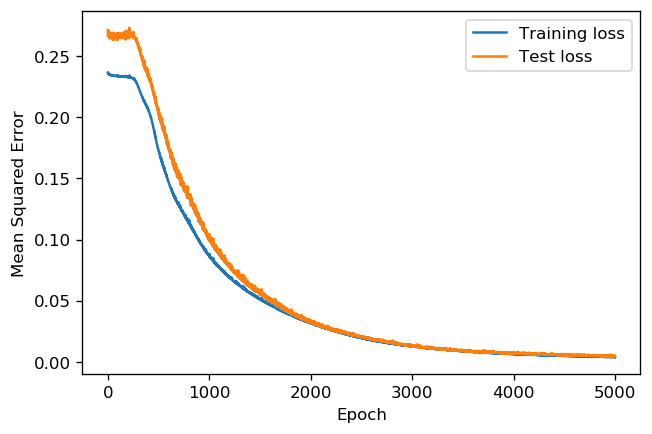

In [33]:
loss_history = np.array(loss_history)
test_loss_history = np.array(test_loss_history)
fig, ax = plt.subplots(dpi=120)
ax.plot(loss_history[:,0], loss_history[:,1], label="Training loss")
ax.plot(test_loss_history[:,0], test_loss_history[:,1], label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Squared Error")
ax.legend()

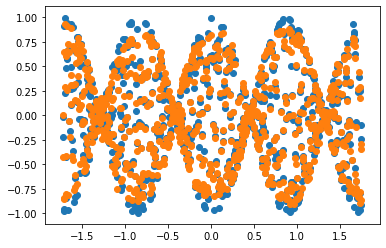

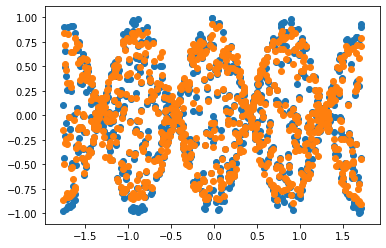

In [34]:
#Plots
x_train = X_train.data.numpy()[:,0]
y_train = X_train.data.numpy()[:,1]
f_train_true = Y_train.data.numpy()[:,0]
f_train_pred = dn(X_train).data.numpy()

plt.figure()
plt.scatter(x_train,f_train_true)
plt.scatter(x_train,f_train_pred)

plt.figure()
plt.scatter(y_train,f_train_true)
plt.scatter(y_train,f_train_pred)

# Changing N

Training set shape (80, 2)
Test set shape (80, 1)
Epoch: 200, Train loss: 0.2281, Test loss: 0.2606
Epoch: 400, Train loss: 0.2050, Test loss: 0.2279
Epoch: 600, Train loss: 0.1768, Test loss: 0.2401
Epoch: 800, Train loss: 0.1608, Test loss: 0.2317
Epoch: 1000, Train loss: 0.1207, Test loss: 0.2589
Epoch: 1200, Train loss: 0.0927, Test loss: 0.2578
Epoch: 1400, Train loss: 0.0745, Test loss: 0.2770
Epoch: 1600, Train loss: 0.0585, Test loss: 0.2134
Epoch: 1800, Train loss: 0.0477, Test loss: 0.1893
Epoch: 2000, Train loss: 0.0416, Test loss: 0.2028
Epoch: 2200, Train loss: 0.0359, Test loss: 0.1795
Epoch: 2400, Train loss: 0.0325, Test loss: 0.1830
Epoch: 2600, Train loss: 0.0295, Test loss: 0.1676
Epoch: 2800, Train loss: 0.0278, Test loss: 0.1407
Epoch: 3000, Train loss: 0.0221, Test loss: 0.1563
Epoch: 3200, Train loss: 0.0183, Test loss: 0.1454
Epoch: 3400, Train loss: 0.0134, Test loss: 0.1516
Epoch: 3600, Train loss: 0.0093, Test loss: 0.1656
Epoch: 3800, Train loss: 0.0060, Tes

Epoch: 2400, Train loss: 0.0127, Test loss: 0.0175
Epoch: 2600, Train loss: 0.0102, Test loss: 0.0151
Epoch: 2800, Train loss: 0.0086, Test loss: 0.0127
Epoch: 3000, Train loss: 0.0067, Test loss: 0.0094
Epoch: 3200, Train loss: 0.0054, Test loss: 0.0075
Epoch: 3400, Train loss: 0.0043, Test loss: 0.0061
Epoch: 3600, Train loss: 0.0035, Test loss: 0.0048
Epoch: 3800, Train loss: 0.0031, Test loss: 0.0040
Epoch: 4000, Train loss: 0.0026, Test loss: 0.0035
Epoch: 4200, Train loss: 0.0024, Test loss: 0.0032
Epoch: 4400, Train loss: 0.0022, Test loss: 0.0030
Epoch: 4600, Train loss: 0.0021, Test loss: 0.0025
Epoch: 4800, Train loss: 0.0021, Test loss: 0.0025
Epoch: 5000, Train loss: 0.0019, Test loss: 0.0024
Training set shape (1920, 2)
Test set shape (1920, 1)
Epoch: 200, Train loss: 0.2473, Test loss: 0.2360
Epoch: 400, Train loss: 0.1986, Test loss: 0.1955
Epoch: 600, Train loss: 0.1311, Test loss: 0.1297
Epoch: 800, Train loss: 0.0620, Test loss: 0.0667
Epoch: 1000, Train loss: 0.0409,

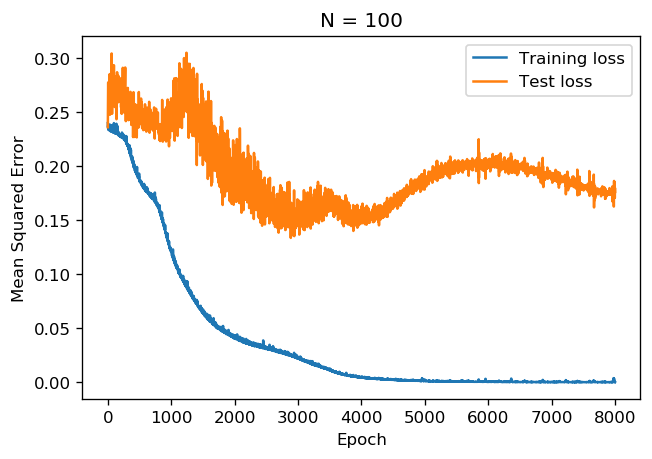

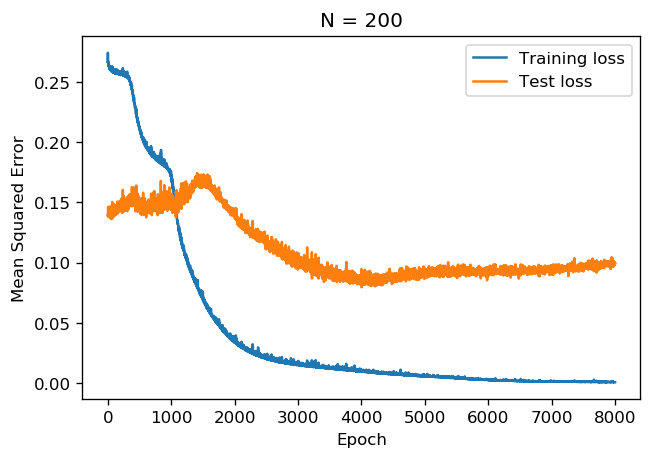

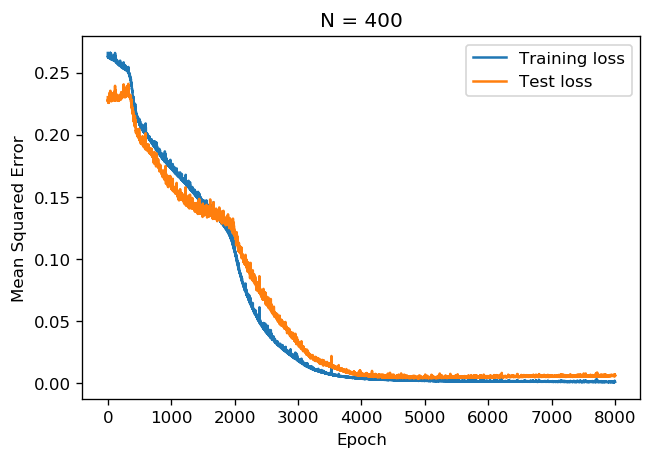

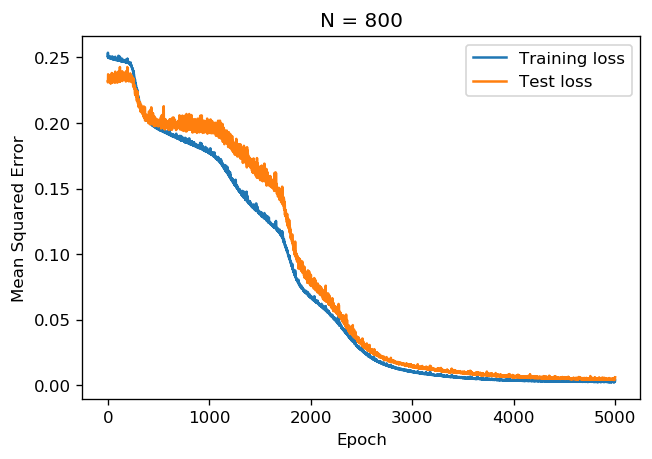

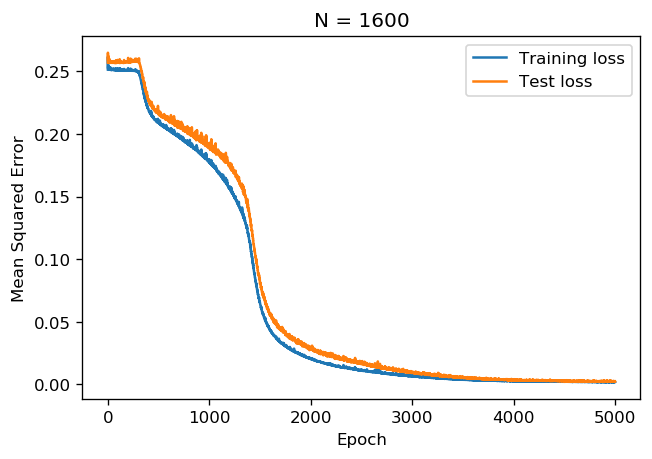

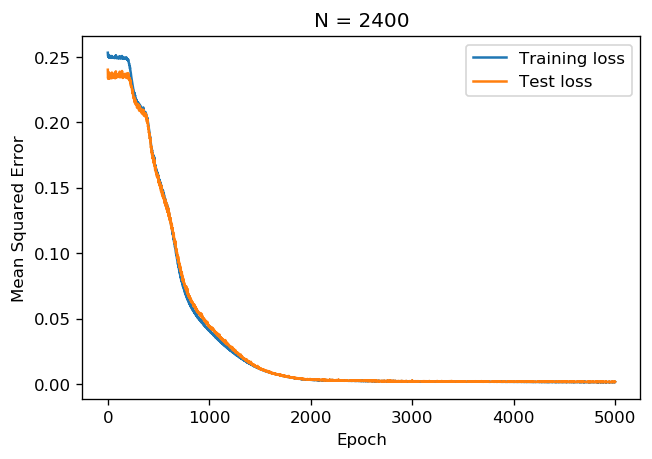

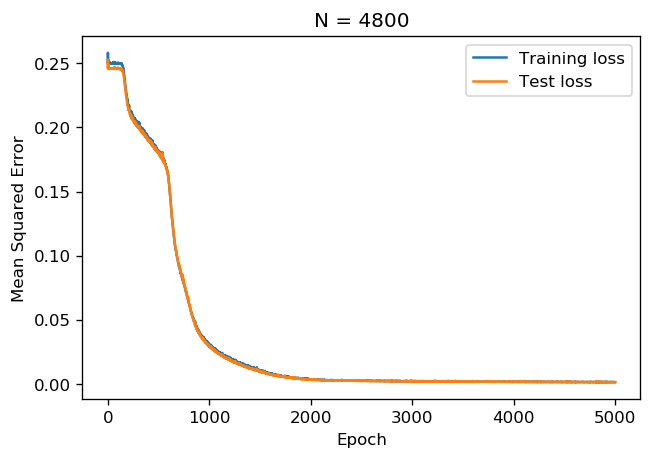

In [47]:
%%time
#samples
Nvals = [100, 200, 400, 800, 1600, 2400, 4800]
max_epochs = [8000, 8000, 8000, 5000, 5000, 5000, 5000]
trainlosses = []
testlosses = []

for i in range(len(Nvals)):
    N = Nvals[i]
    
    #sample on LHS
    design = pyDOE.lhs(2, samples = N)
    x = 50 + 4*design[:,0]
    y = 50 + 4*design[:,1]
    f = np.cos(np.pi*x)*np.cos(np.pi*y)

    #Prepare training and test data
    X = np.transpose(np.vstack((x,y)))
    Y = f.reshape(-1,1)

    #Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8,shuffle=True)
    print("Training set shape", X_train.shape)
    print("Test set shape", Y_train.shape)

    #Normalize training data
    mu = X_train.mean(axis = 0)
    sigma = X_train.std(axis = 0)
    X_train = (X_train - mu)/sigma

    #Normalize test data using same parameters used to normalize training data
    X_test = (X_test - mu)/sigma

    #Convert data into PyTorch tensors
    X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
    Y_test = torch.from_numpy(Y_test).type(torch.FloatTensor)

    loss_fn = MSE_loss #as this is a regression problem

    #Instantiate class
    dn = DeepNet()

    #Initialize weights
    #Glorot initialization
    [W, b] = list(dn.FC1.parameters())
    W = glorot_init_mat(W.shape)
    b.data.fill_(0)

    [W, b] = list(dn.FC2.parameters())
    W = glorot_init_mat(W.shape)
    b.data.fill_(0)

    [W, b] = list(dn.FC3.parameters())
    W = glorot_init_mat(W.shape)
    b.data.fill_(0)

    #Training, perform backprop
    MAX_EPOCHS = max_epochs[i]
    LRATE = 1e-3
    BATCH_SIZE = int(N/4)

    #Data handling
    traindata = NLRDataset(X_train,Y_train)
    traindataloader = torch.utils.data.DataLoader(traindata,batch_size=BATCH_SIZE,shuffle=True)

    #Use Adam for training
    optimizer = torch.optim.Adam(dn.parameters(), lr=LRATE)

    loss_history = []
    test_loss_history = []

    for epoch in range(MAX_EPOCHS):
        #Train net in batches
        for Xbatch, Ybatch in traindataloader:
            Ypred = dn(Xbatch)
            loss = loss_fn(Ypred,Ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #calculate train loss
        Ytrain_pred = dn(X_train)
        train_loss = loss_fn(Ytrain_pred,Y_train)
        #calculate test loss
        Ytest_pred = dn(X_test)
        test_loss = loss_fn(Ytest_pred,Y_test)
        #append loss history
        loss_history.append([epoch,np.float(train_loss)])
        test_loss_history.append([epoch,np.float(test_loss)])
        if (epoch+1) % 200 == 0:
            print("Epoch: {}, Train loss: {:.4f}, Test loss: {:.4f}".format((epoch+1), train_loss, test_loss))

    loss_history = np.array(loss_history)
    test_loss_history = np.array(test_loss_history)
    fig, ax = plt.subplots(dpi=120)
    ax.plot(loss_history[:,0], loss_history[:,1], label="Training loss")
    ax.plot(test_loss_history[:,0], test_loss_history[:,1], label="Test loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Mean Squared Error")
    ax.set_title("N = {}".format(N))
    ax.legend()
    
    trainlosses.append(loss_history[-1,1])
    testlosses.append(test_loss_history[-1,1])

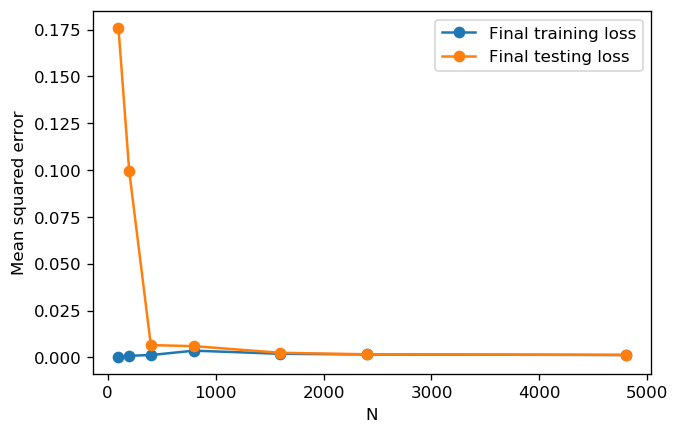

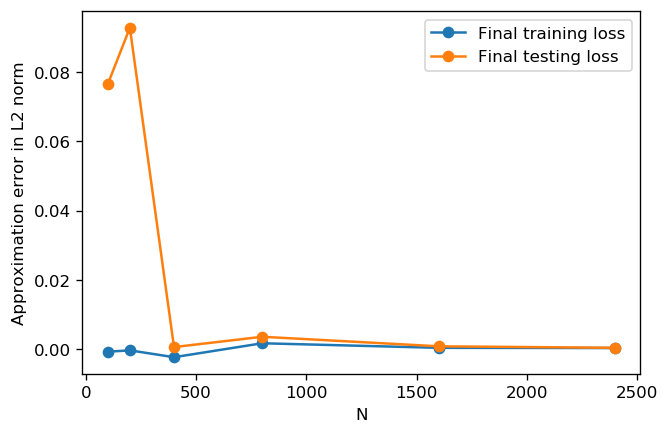

In [55]:
train_app_error = []
test_app_error = []
for i in range(len(Nvals)-1):
    train_app_error.append(trainlosses[i] - trainlosses[i+1])
    test_app_error.append(testlosses[i] - testlosses[i+1])

Nvalsapp = Nvals[0:len(Nvals)-1]

#Plots
fig, ax = plt.subplots(dpi=120)
ax.plot(np.array(Nvals), np.array(trainlosses), 'o-', label="Final training loss")
ax.plot(np.array(Nvals), np.array(testlosses), 'o-', label="Final testing loss")
ax.set_xlabel("N")
ax.set_ylabel("Mean squared error")
ax.legend()

fig, ax = plt.subplots(dpi=120)
ax.plot(np.array(Nvalsapp), np.array(train_app_error), 'o-', label="Final training loss")
ax.plot(np.array(Nvalsapp), np.array(test_app_error), 'o-', label="Final testing loss")
ax.set_xlabel("N")
ax.set_ylabel("Approximation error in L2 norm")
ax.legend()